In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import optimizers

In [19]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset.csv', usecols=['Main Diagnosis'] + ['word_' + str(i) for i in range(100)])

# Display the first few rows to understand the structure
print(data.head())
print(nlp_data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

          Arrival Time Severity Level           Deparment  \
0  2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1  2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2  2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3  2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4  2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

                                   Main Diagnosis       Discharge Time  \
0                               Pain, unspecified  2023-12-13 16:43:00   
1   

In [20]:
#df = pd.DataFrame(data, columns=['Main Diagnosis'])
import re #re stands for the regular expression module, which provides a set of tools for matching and manipulating text patterns.

# Step 1: Lowercase all the entries in the 'Main Diagnosis' column
data['Main Diagnosis'] = data['Main Diagnosis'].str.lower()

# Step 2: Handle missing values by replacing NaN or empty strings with "Unknown"
data['Main Diagnosis'] = data['Main Diagnosis'].fillna('Unknown')

# Step 3: Remove punctuation or special characters from the diagnoses
data['Main Diagnosis'] = data['Main Diagnosis'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Step 4: Standardize some common diagnoses (as an example)
data['Main Diagnosis'] = data['Main Diagnosis'].replace({
    'acute upper respiratory infection unspecified': 'upper respiratory infection',
    'low back pain': 'back pain',
   
})

print(data['Main Diagnosis'])

0                                         pain unspecified
1                                                back pain
2                              upper respiratory infection
3                                                epistaxis
4                              upper respiratory infection
                               ...                        
97085                                   asthma unspecified
97086                          upper respiratory infection
97087                          upper respiratory infection
97088    cutaneous abscess furuncle and carbuncle unspe...
97089                          pain in limb multiple sites
Name: Main Diagnosis, Length: 97090, dtype: object


In [21]:
# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])

# Extract hour from Arrival Time
data['Hour'] = data['Arrival Time'].dt.hour

# Use 'Hour'和'Main Diagnosis Encoded' for training
# X = data[['Hour', 'Main Diagnosis Encoded','Waiting Time (Minutes)']].values
# X = data[['Hour', 'Waiting Time (Minutes)']].values

In [23]:
# Error need to be fixed.
# Method 1: Combine datasets on 'Main Diagnosis'
combined_data = pd.merge(data, nlp_data, on='Main Diagnosis')

# Method 2: Merge datasets based on 'Main Diagnosis' turned into an index, which should be made lower case for both datasets.
# data.set_index('Main Diagnosis', inplace=True)
# nlp_data.set_index('Main Diagnosis', inplace=True)
# combined_data = data.join(nlp_data, how='left', rsuffix='_nlp')
print(combined_data.head())

KeyboardInterrupt: 

In [ ]:
# Assuming 'word_0' to 'word_99' are the vectorized NLP features
feature_columns = ['word_' + str(i) for i in range(100)]  # Generate list of NLP feature columns
feature_columns += ['Waiting Time (Minutes)', 'Length of Stay (Minutes)']  # Add other numerical features

# Scale features to [0, 1] - important for neural network models
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns]).fillna(0)

# Autoencoder

In [8]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42, shuffle=True)

In [9]:
# Build the Autoencoder Model

# Define the autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer) #16
encoded = Dense(64, activation='relu')(encoded) #8

# Decoder
# decoded = Dense(input_dim, activation='sigmoid')(encoded)
decoded = Dense(128, activation='relu')(encoded) #16
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [10]:
# Train the autoencoder
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
304/304 [==============================] - 2s 2ms/step - loss: 726.9749 - val_loss: 722.2896
Epoch 2/50
304/304 [==============================] - 0s 2ms/step - loss: 719.9175 - val_loss: 719.5588
Epoch 3/50
304/304 [==============================] - 1s 2ms/step - loss: 718.3477 - val_loss: 718.6949
Epoch 4/50
304/304 [==============================] - 1s 2ms/step - loss: 717.7657 - val_loss: 718.3081
Epoch 5/50
304/304 [==============================] - 0s 2ms/step - loss: 717.4798 - val_loss: 718.0996
Epoch 6/50
304/304 [==============================] - 1s 2ms/step - loss: 717.3171 - val_loss: 717.9746
Epoch 7/50
304/304 [==============================] - 1s 2ms/step - loss: 717.2159 - val_loss: 717.8937
Epoch 8/50
304/304 [==============================] - 1s 2ms/step - loss: 717.1492 - val_loss: 717.8387
Epoch 9/50
304/304 [==============================] - 0s 1ms/step - loss: 717.1026 - val_loss: 717.7999
Epoch 10/50
304/304 [==============================] - 0s 2ms/st

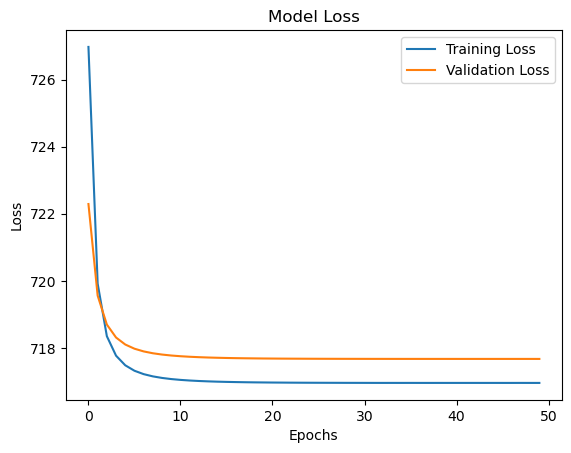

In [11]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

607/607 [==============================] - 1s 2ms/step


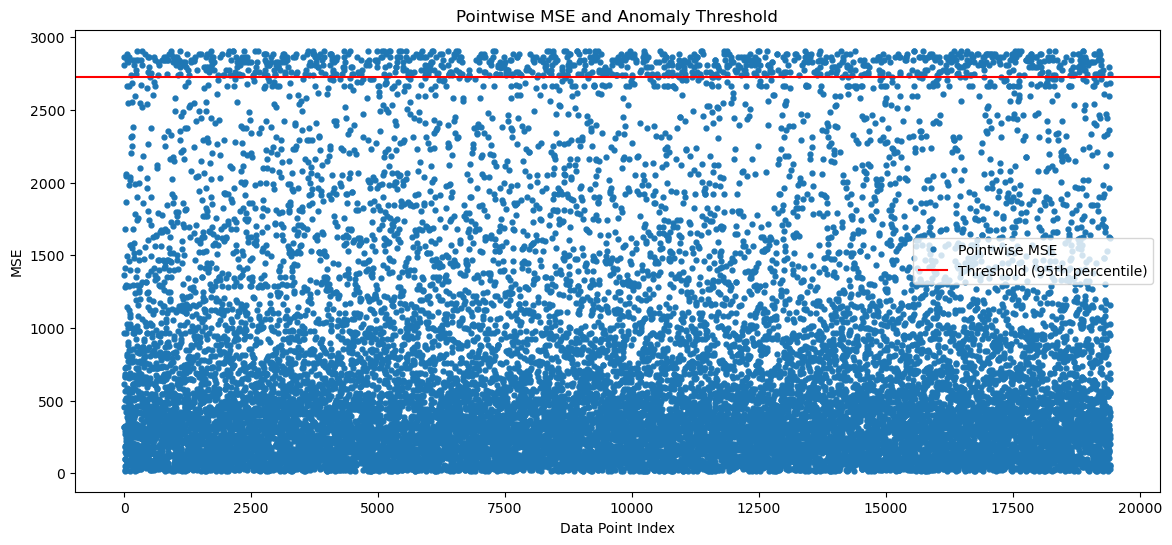

In [12]:
# Detect Anomalies Using Reconstruction Error

# Get the reconstruction loss on the test set
predictions = autoencoder.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Set a threshold for anomaly detection
mse_threshold = np.quantile(mse, 0.95) 

# Mark data points with errors above the threshold as anomalies
outliers = mse > mse_threshold

# Plot the pointwise MSE and the anomaly threshold
plt.figure(figsize=(14, 6))
plt.plot(mse, marker='o', ms=3.5, linestyle='', label='Pointwise MSE')
plt.axhline(y=mse_threshold, color='r', linestyle='-', label='Threshold (95th percentile)')
plt.title('Pointwise MSE and Anomaly Threshold')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [13]:
# Print the anomalies
data_test = data.iloc[X_test.index]
data_test['Anomaly'] = outliers
anomalies = data_test[data_test['Anomaly'] == True]
print("Anomalies detected at following times:")
# print(anomalies[['Arrival Time', 'Main Diagnosis']])
print(anomalies[['Arrival Time']])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

# Isolation Forest

## Still working on it

In [ ]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit the model to the data
iso_forest.fit(scaled_features)

# Predict anomalies (-1 means anomaly, 1 means normal)
predictions = iso_forest.predict(scaled_features)

# Add predictions to the original data (for easier analysis)
data['anomaly'] = predictions

# Display the count of anomalies detected
print("Anomalies detected:", np.sum(predictions == -1))


In [ ]:
# Filter the data to show only the anomalies
anomalies = data[data['anomaly'] == -1]

# Display the first few anomalies
print("Anomalous Data:")
print(anomalies.head())

In [ ]:
# Visualizing using two features for simplicity (Length of Stay and Waiting Time)
plt.figure(figsize=(10, 6))
plt.scatter(data['Length of Stay (Minutes)'], data['Waiting Time (Minutes)'], 
            c=data['anomaly'], cmap='coolwarm', marker='o')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Length of Stay (Minutes)')
plt.ylabel('Waiting Time (Minutes)')
plt.show()